In [14]:
import requests

Settings:

In [15]:
topic = "climate_change"
organizers = ["Last Generation (Germany)"]

In [16]:
res = requests.post(
    # "https://api.dev.mediaimpactmonitor.app/events",
    "http://localhost:8000/events",
    json={
        "event_type": "protest",
        "source": "acled",
        "topic": "climate_change",
        "start_date": "2023-07-01",
        "end_date": "2023-12-31",
        "topic": topic,
        "organizers": organizers,
    },
)
events = res.json()["data"]
event_ids = [event["event_id"] for event in events]
events[0]

{'event_id': '9064cc0660a50363ec2d44a8fe51b376',
 'event_type': 'protest',
 'source': 'acled',
 'date': '2023-12-15',
 'organizers': ['Last Generation (Germany)'],
 'description': 'On 15 December 2023, about 15 Last Generation activists blocked streets at various places across Koln (Nordrhein-Westfalen), demanding immediate climate change. Law enforcers quickly removed them and resumed traffic.'}

In [17]:
import pandas as pd
import numpy as np
import altair as alt

df = pd.DataFrame(events)
df["organizer"] = df["organizers"].apply(lambda x: x[0] if x else "nooo")
df["y"] = np.random.normal(loc=0, scale=1, size=len(df))
df["participants"] = np.random.randint(100, 1000, size=len(df))
df.head()

alt.Chart(df).mark_circle().encode(
    x="date:T",  # T: temporal
    y="y:Q",  # Q: quantitative
    color="organizer:N",  # N: nominal
    size="participants:Q",  # Quantitative size encoding
).properties(width=600, height=300)

alt.Chart(...)

In [18]:
res = requests.post(
    # "https://api.dev.mediaimpactmonitor.app/trend",
    "http://localhost:8000/trend",
    json={
        "trend_type": "keywords",
        "media_source": "news_online",
        "topic": "climate_change",
        "query": '"Letzte Generation"',
        "start_date": "2023-01-01",
        "end_date": "2023-12-31",
    },
)
data = res.json()["data"]

In [19]:
df = pd.DataFrame(list(data.items()), columns=["date", "value"])
df["date"] = pd.to_datetime(df["date"])  # Convert the date column to datetime type

alt.Chart(df).mark_line(point=True).encode(
    x="date:T",  # T: temporal
    y="value:Q",  # Q: quantitative
    tooltip=["date", "value"],
).properties(width=600, height=300)

alt.Chart(...)

In [24]:
res = requests.post(
    # "https://api.dev.mediaimpactmonitor.app/impact",
    "http://localhost:8000/impact",
    json={
        "cause": event_ids,
        "effect": {
            "trend_type": "keywords",
            "media_source": "news_online",
            "query": '"Klima*"',
        },
        "method": "interrupted_time_series",
    },
)
data = res.json()["data"]

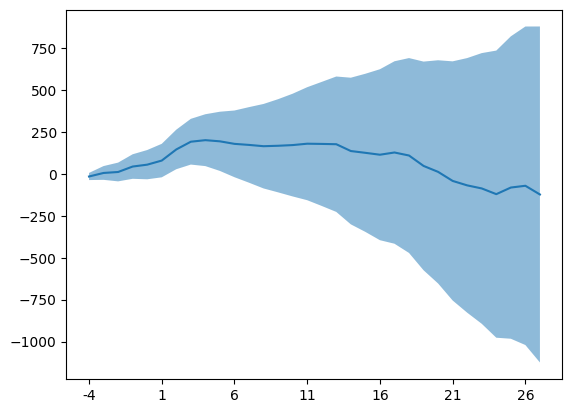

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

pd.Series(data["impact_mean"]).plot()
plt.fill_between(
    pd.Series(data["impact_mean"]).index,
    pd.Series(data["impact_mean_lower"]).values,
    pd.Series(data["impact_mean_upper"]).values,
    alpha=0.5,
)

count    151.000000
mean      12.453919
std      106.016563
min     -172.573853
25%      -53.838501
50%      -13.332367
75%       60.875992
max      415.842525
dtype: float64


<Axes: >

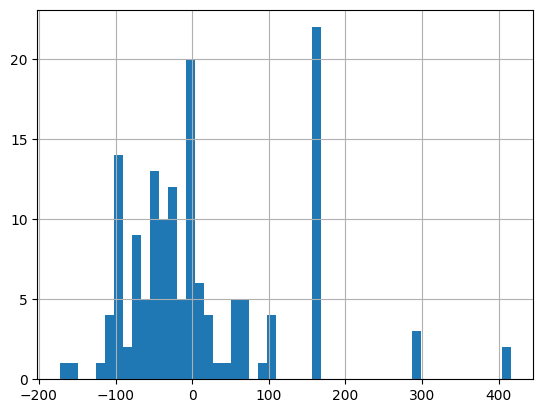

In [22]:
impacts__ = pd.Series(
    [list(ts.values())[4 + 14] for ts in data["individual_impacts"].values()]
)
print(impacts__.describe())
impacts__.hist(bins=50)

In [23]:
from scipy.stats import normaltest

normaltest(impacts__)

NormaltestResult(statistic=38.361141607881784, pvalue=4.677178450886598e-09)

Small p-value means that it's likely not normal. (However, large p-value does not mean anything, e. g. it can be due to small sample size.)
See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html.